### Simulating the dynamics of a levitated nanoparticle

This notebook will show how to simulate a levitated nanoparticle under the action of a cubic force considering the presence of a Butterworth filter in our electronics setup. To do this we are going to:

* Define an environment where the dynamics of a levitated nanoparticle is considered;
* Generate traces via Euler-Maruyama simulation;
* Making the plots showed in the *Results* section of the paper.

A brief summary of the organization of this notebook:

### Summary

- [1 - Packages and imports](#1)

- [2 - Creating the virtual nano-particle](#2)

- [3 - Generating traces](#3)

- [4 - Plots and comparison with theoretical predictions](#4)

<a name='1'></a> 
### 1. Packages and imports

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from non_linearity.environment import Particle
from non_linearity.simulation import simulation_filter, simulation
import non_linearity.utils.constants as ct
from scipy import signal as sn
from scipy.optimize import curve_fit

In [2]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

<a name='2'></a> 
### 2. Creating the virtual nano-particle

Here we are going to define some parameters for simulations. First, the particle frequency $f$, from this, we know the period $T$ and the angular frequency $\omega$. The period is going to be used to define the maximum simulation time $t_{max}$. The parameter $M$ represents the number of traces that are going to be created, we will simulate three different cases. A scenario with no filter, and two scenarious with Butterworth filters with distinct bandwidths.

In [5]:
freq = 81.5e3
omega = 2*np.pi*freq
T = 1 / freq
max_time = 500 * T
M = 500
delta_t = 2e-7
N_time = int(max_time / delta_t)
# psd_stamps = int(N_time / 2 + 1)
t = np.linspace(0, max_time, int(N_time))
gamma = 13e3
gain = 1.2e6

In [6]:
env = Particle(omega, gamma, radius=73e-9)

In [7]:
def lorentzian(omega,A,center,gamma,base):
    num = A*gamma
    den = (center**2-omega**2)**2+omega**2*gamma**2
    return num/den + base

<a name='3'></a> 
### 3. Generating traces

To create the traces we will call a function from our package, the `simulation` will run the Euler-Maruyama algorithm using Numba, this will allow for an optimized run, reducing time consumption. The difference from the other simulation function used in the notebook number `1.` is that here we take in account the presence of the filter before computign the control signal. The implementation of the Butterworth considered the filter as a IIR (Infinite Impulse Response) system. We also defined a `psd` function to run the `welch` method from `scipy.signal` on dictionary of traces.

In [8]:
def fit_psd(traces, delta_t):
    freq, power = psd(traces, delta_t)
    p0 =  [1e15, 2*np.pi*79000.0, 13e3, 0]
    ans, cov = curve_fit(lorentzian, freq, power, p0=p0, absolute_sigma=True, maxfev=10000)
    fitted_power = lorentzian(freq, *ans)
    return power, fitted_power, freq, ans


def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[0]):
        freq, pxx = sn.welch(traces[i,:], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[1]))
        if not np.isnan(pxx.max()) and not pxx.max() > 1e12:
            pxxs.append(pxx)
    return freq, np.array(pxxs).mean(axis=0)
 

def generate_traces(env, gain, delta_t, N_time,  M, band_ranges):
    f_c = env.__omega__/(2*np.pi)
    cubic_delayed = {i: [None] for i in band_ranges}
    print("-- Creating traces --")
    for key in tqdm(cubic_delayed.keys()):
        cubic = np.zeros(shape=(M, N_time))
        if key != 0:
            b, a = sn.butter(2, [f_c-key, f_c+key], fs=1/delta_t, btype='band', analog=False)
            for i in range(M):
                data = simulation_filter(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, gain*(env.zp_x**3/env.zp_p), a, b)
                data = np.array(data)
                cubic[i, :] = data
            cubic_delayed[key] = cubic
        else:
            for i in range(M):
                data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, gain*(env.zp_x**3/env.zp_p), 0)
                data = np.array(data)
                cubic[i, :] = data
            cubic_delayed[key] = cubic
    print("-- Analysing and making PSD --")
    return cubic_delayed

In [9]:
band_range = [0, 1e3, 5e4]
cubic_delayed = generate_traces(env, gain, delta_t, N_time, M, band_range)

-- Creating traces --


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:20<00:00,  6.75s/it]

-- Analysing and making PSD --


In [10]:
band_range = [0]
ref = generate_traces(env, 0, delta_t, N_time, M, band_range)

-- Creating traces --


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

-- Analysing and making PSD --


<a name='4'></a> 
### 4. Plots and comparison with theoretical predictions

Here we will define the autocorrelation functions, both zero and first order corrections. This will be used to compared the theory with simulation, which will be done in the last cell, via the plots that will be saved under the name `psd_filters.png`.

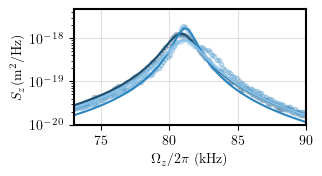

<Figure size 7020x4200 with 0 Axes>

In [11]:
ax = plt.gca()
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
ax.figure.set_size_inches(3, 1.5, forward=True)
ax.grid(alpha = 0.4)
colors = ['#1B4F72', '#2E86C1', '#85C1E9']
labels = [r'$G_{fb}=\,$', r'$G_{fb} =\,$', r'$G_{fb}=\,$']
factors = [0.8768, 1, 0.86]
for i, key in enumerate(cubic_delayed.keys()):#gain, color, label, factor in zip(gains, colors, labels, factors):
    power, fitted_power, freq, _ = fit_psd(cubic_delayed[key], delta_t)
    ax.plot(freq/1000, fitted_power*env.zp_x**2, label=key, color=colors[i])#, color=color, label=label+str(float_gain)+r' $\times 10^6\textrm{N/m}{}^3$')
    ax.scatter(freq/1000, power*env.zp_x**2, alpha=0.25, s=10, color=colors[i])#, label='_{}'.format(label))
    ax.set_xlim([73, 90])
    ax.set_ylim([10**-20, 5*max(power*env.zp_x**2)])
    ax.set_yscale('log')
    ax.set(ylabel=r'$S_z(\textrm{m}{}^2$/Hz)')
    ax.set(xlabel=r'$\Omega_z/2\pi$ (kHz)')
#ax.legend()
plt.savefig('../plots/psds_filter.png', dpi=300, bbox_inches='tight')
plt.show()